In [1]:
import numpy as np
from scipy.linalg import sqrtm  # Matrix Square Root
from scipy.special import softmax # Softmax

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

import matplotlib.pyplot as plt
from matplotlib import animation as anm
from IPython.display import HTML

# Utilities

In [2]:
def plot_graph(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(24,8))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

# Data Exploration

In [3]:
graph = nx.karate_club_graph()

In [4]:
graph.number_of_nodes(), graph.number_of_edges()

(34, 78)

In [5]:
communities = greedy_modularity_communities(graph)

In [6]:
colors = np.zeros(graph.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

In [7]:
club_labels  = nx.get_node_attributes(graph, "club")

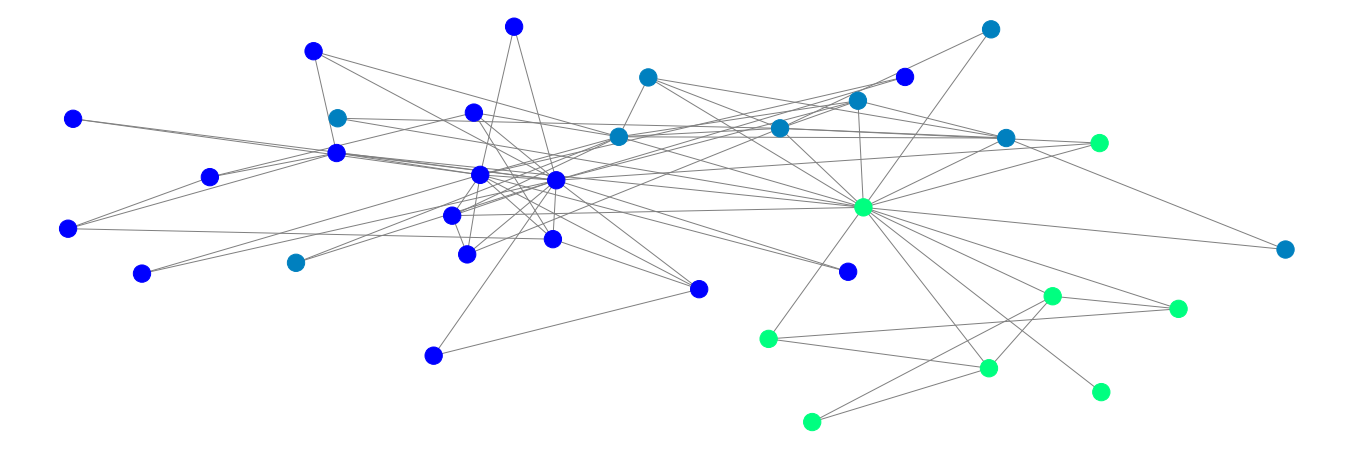

In [8]:
plot_graph(graph, None, colors, cmap='winter', edge_color='gray')

In [9]:
# Ajacency Matrix

A = nx.to_numpy_matrix(graph)
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

$$\widetilde{A} = A+ I$$

$$\hat{A} = D^{-1/2}\widetilde{A}D^{-1/2}$$

In [10]:
# Self Loop
A_mod = A + np.eye(graph.number_of_nodes())

# Degree Matrix
D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())

# D^(-0.5)
D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

# A = D^(0.5)AD^(0.5)
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [11]:
# Input Feathures. 
# [I amtrix will amp the each colum of A to a vector of learnable parameters in first layer]
# [It will result in fulll learnable node embedding.]

X = np.eye(graph.number_of_nodes())

# NN Utility Functions/Classes

In [56]:
def glorot_init(n_in, n_out):
    sd = np.sqrt(6.0 / (n_in + n_out))
    return np.random.uniform(-sd, sd, size=(n_in, n_out))


def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]


def norm_diff(dW, dW_approx, order):
    return np.linalg.norm(dW - dW_approx, order) / (np.linalg.norm(dW, order) + np.linalg.norm(dW_approx, order))

In [13]:
class GradientDescentOptim:
    def __init__(self, lr, wd, **kwargs):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.batch_size = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.batch_size = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out

    @out.setter
    def out(self, y):
        self._out = y

GCN equation is as follow in Kipf's paper.

$$H^{l+1} = \sigma\big(W \hat{A} H^{l} \big)$$

where $\hat{A} H^{l}$ represents message passing.

In [173]:
X.shape, A_hat.shape

((34, 34), (34, 34))

In [ ]:
X @ A_hat

In [65]:
class GCNLayer:
    def __init__(self, n_inputs, n_outputs, activation=None, **kwargs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = kwargs.get("name")
    
    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"

    def forward(self, A, X, W=None):
        """
        A \in (batch_size x batch_size)
        X \in (batch_size x input_length)
        """
        self._X = (A @ X).T
        W = self.W if W is None else W

        H = (W @ self._X) if self.activation is None else self.activation(W @ self._X)

        self._H = H

        return self._H.T
    
    def backward(self, optim, update=True):
        # Gradient wrt to tanh activation
        dtanh = 1 - np.asarray(self._H.T)**2 

        # Gradient multiplied (hadmard product) with incoming gradient from next layers.
        d2 = np.multiply(optim.out, dtanh) 

        # Gradient for previous layer.
        optim._out = d2 @ self.W

        # Gradient for current layer.
        dW = np.asarray(d2.T @ self._X.T) / optim.batch_size 

        # Weight decay update.
        dW_wd = self.W * optim.wd / optim.batch_size
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr 
        
        return dW + dW_wd

In [66]:
class SoftmaxLayer:
    def __init__(self, n_inputs, n_outputs, **kwargs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = kwargs.get("name")
        self._X = None # Used to calculate gradients

    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0)
        
    def forward(self, X, W=None, b=None):
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = (W @ self._X) + b 
        return self.shift(proj).T
    
    def backward(self, optim, update=True):
        # Build mask on loss to mask nodes which are no used.
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        # Derivative of Loss w.r.t. Activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true)) 
        d1 = np.multiply(d1, train_mask)
        
        # Gradients for Previous Layer.
        optim.out = d1 @ self.W
        
        # Gradients for Current Layer
        dW = (d1.T @ self._X.T) / optim.batch_size
        db = d1.T.sum(axis=1) / optim.batch_size
                
        # Weight Decay Update
        dW_wd = self.W * optim.wd / optim.batch_size
        
        if update:   
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW + dW_wd, db.reshape(self.b.shape)

In [67]:
# Instantiate the Layers

gcn_1 = GCNLayer(graph.number_of_nodes(), 3, activation=np.tanh, name='gcn-1')
sm_1 = SoftmaxLayer(3, n_classes, name="sm-1")
opt = GradientDescentOptim(lr=0, wd=1.)

In [68]:
output_gcn_1 = gcn_1.forward(A_hat, X)
output_gcn_1.shape

(34, 3)

In [69]:
output_sm_1 = sm_1.forward(output_gcn_1)
output_sm_1.shape

(34, 3)

In [70]:
opt(output_sm_1, labels)

# Gradients Checking

In [71]:
# Get Gradients for softmax layer using Finite Difference method.

def get_grads(inputs, layer, argname, labels, eps=1e-4, wd=0):
    cp = getattr(layer, argname).copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        #print(f"Parm {argname}_{i}")
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predp = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        Jp = xent(predp, labels).mean() + wd_term
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        Jn = xent(predm, labels).mean() + wd_term
        
        # grad
        grads[i] = ((Jp - Jn) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

In [72]:
# Gradient using Finite Differnece

dW_approx = get_grads((output_gcn_1,), sm_1, "W", labels, eps=1e-4, wd=opt.wd)
db_approx = get_grads((output_gcn_1,), sm_1, "b", labels, eps=1e-4, wd=opt.wd)

In [73]:
# Gradient using Automatic Diffrentiation (Chain Rule)

dW, db = sm_1.backward(opt, update=False)

In [74]:
# Error L2 Norm

norm_diff(dW, dW_approx, 2), norm_diff(db, db_approx, 2)

(3.5836122056067775e-11, 5.403478787556215e-10)

In [75]:
# Get Gradients for GCN layer using Finite Difference method.

def get_gcn_grads(inputs, gcn, sm_layer, labels, eps=1e-4, wd=0):
    cp = gcn.W.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jp = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jn = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # grad
        grads[i] = ((Jp - Jn) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

In [76]:
# Gradient using Finite Differnece

dW2_approx = get_gcn_grads((A_hat, X), gcn_1, sm_1, labels, eps=1e-4, wd=opt.wd)

In [77]:
# Gradient using Automatic Diffrentiation (Chain Rule)

dW2 = gcn_1.backward(opt, update=False)

In [78]:
# Error L2 Norm

norm_diff(dW, dW_approx, 2), norm_diff(db, db_approx, 2)

(3.5836122056067775e-11, 5.403478787556215e-10)

# Graph Convolution Network

In [81]:
# A GCN Class

class GCNModel:
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, seed=0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        
        np.random.seed(seed)
        
        self.layers = list()
        # Input layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)
        
        # Hidden layers
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[0], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)
            
        # Output layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.layers.append(sm_out)
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])
    
    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return np.asarray(H)
    
    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)
        
        # Softmax
        p = self.layers[-1].forward(H)
        
        return np.asarray(p)

In [82]:
model = GCNModel(
                  n_inputs = graph.number_of_nodes(), 
                  n_outputs = n_classes, 
                  n_layers = 2,
                  hidden_sizes = [16, 2], 
                  activation = np.tanh,
                  seed = 69420
)

model

GCN: W_in (34, 16)
GCN: W_h0 (16, 16)
GCN: W_h1 (16, 2)
Softmax: W_sm (2, 3)

In [83]:
y_pred = model.forward(A_hat, X)
embed = model.embedding(A_hat, X)

xent(y_pred, labels).mean()

1.105750125043968

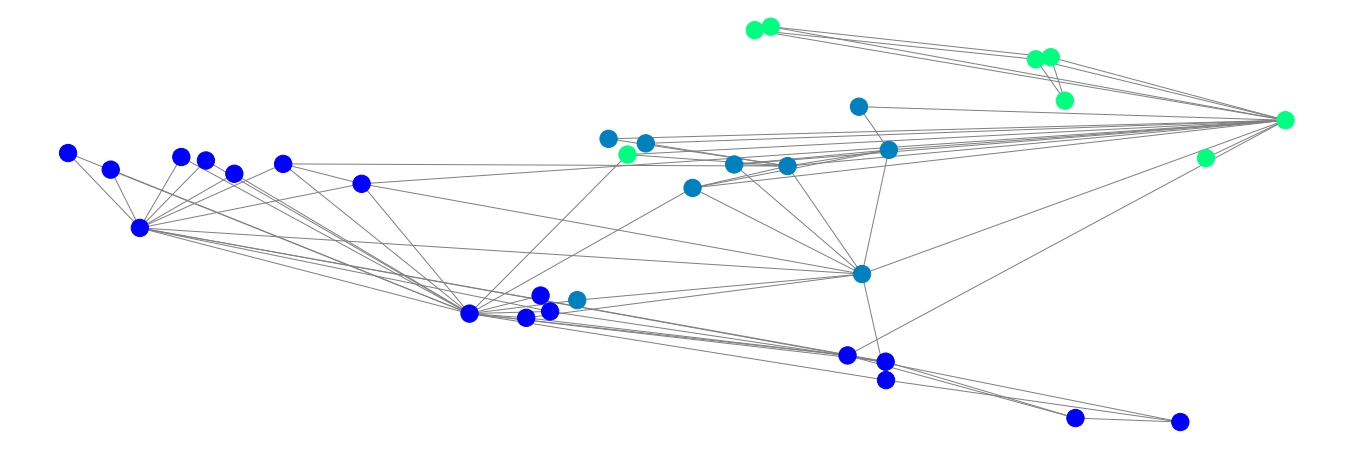

In [84]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
plot_graph(graph, None, colors, pos = pos, cmap='winter', edge_color='gray')

# Training GCNs

In [165]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array(list(set.difference(set(np.arange(labels.shape[0])), set(train_nodes))))
opt = GradientDescentOptim(lr=2e-2, wd=2.5e-2)

model = GCNModel(
                  n_inputs = graph.number_of_nodes(), 
                  n_outputs = n_classes, 
                  n_layers = 2,
                  hidden_sizes = [16, 2], 
                  activation = np.tanh,
                  seed = 69420
)

In [166]:
history = {"train-loss": [np.inf], "test-loss": [np.inf], "train-accuracy": [0], "test-accuracy": [0], "embeddings": []}

THRESHOLD = 1e6
PATIENCE = 25
EPOCHS = 15000

trigger = 0
min_loss = np.inf
for epoch in range(EPOCHS):
    # Forward Pass
    y_pred = model.forward(A_hat, X)
    
    # Optimizer Steps
    opt(y_pred, labels, train_nodes)
    
    # Backpropgation
    for layer in reversed(model.layers):
        layer.backward(opt, update=True)

    # Store Embeddings
    if epoch%10 == 0:
        history["embeddings"].append(model.embedding(A_hat, X))

    # Store Loss
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))
    history["train-accuracy"].append(acc[train_nodes].mean())
    history["test-accuracy"].append(acc[test_nodes].mean())

    # Caculate Loss
    loss = xent(y_pred, labels)
    train_loss = loss[train_nodes].mean()
    test_loss = loss[test_nodes].mean()
    
    # Early Stopping
    min_loss = min(min_loss, np.min(history["test-loss"]))
    if min_loss - test_loss < 0:
        trigger += 1
    else:
        trigger = 0

    if trigger >= PATIENCE:
        print("Test Loss Increasing. Training Over")
        break
    
    # Cache Loss
    history["train-loss"].append(train_loss)
    history["test-loss"].append(test_loss)

    # Printing Summary
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1:04}/{EPOCHS} Train Loss: {train_loss:.6f} Test Loss: {test_loss:.6f}")

Epoch: 0001/15000 Train Loss: 1.087416 Test Loss: 1.107524
Epoch: 0101/15000 Train Loss: 1.040800 Test Loss: 1.076014
Epoch: 0201/15000 Train Loss: 0.980802 Test Loss: 1.025653
Epoch: 0301/15000 Train Loss: 0.894317 Test Loss: 0.944633
Epoch: 0401/15000 Train Loss: 0.777739 Test Loss: 0.829463
Epoch: 0501/15000 Train Loss: 0.652143 Test Loss: 0.709035
Epoch: 0601/15000 Train Loss: 0.555322 Test Loss: 0.624565
Epoch: 0701/15000 Train Loss: 0.491080 Test Loss: 0.577670
Epoch: 0801/15000 Train Loss: 0.444322 Test Loss: 0.552361
Epoch: 0901/15000 Train Loss: 0.405459 Test Loss: 0.538107
Epoch: 1001/15000 Train Loss: 0.371127 Test Loss: 0.530014
Epoch: 1101/15000 Train Loss: 0.340691 Test Loss: 0.525893
Epoch: 1201/15000 Train Loss: 0.314126 Test Loss: 0.524512
Test Loss Increasing. Training Over


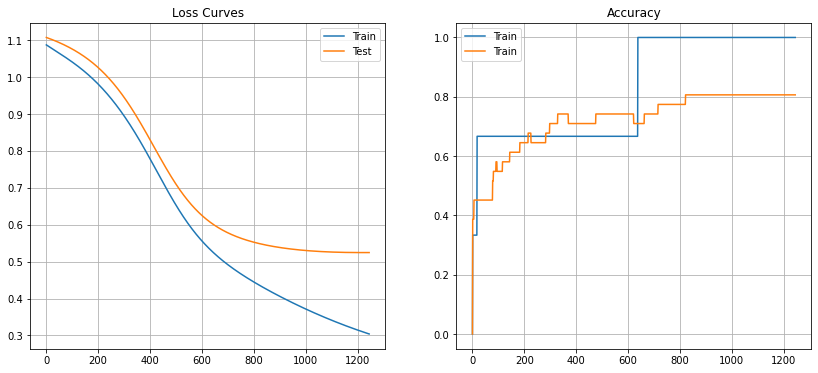

In [167]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history["train-loss"], label='Train')
plt.plot(history["test-loss"], label='Test')
plt.legend()
plt.grid()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(history["train-accuracy"], label='Train')
plt.plot(history["test-accuracy"], label='Train')

plt.legend()
plt.grid()
plt.title("Accuracy")

plt.show()

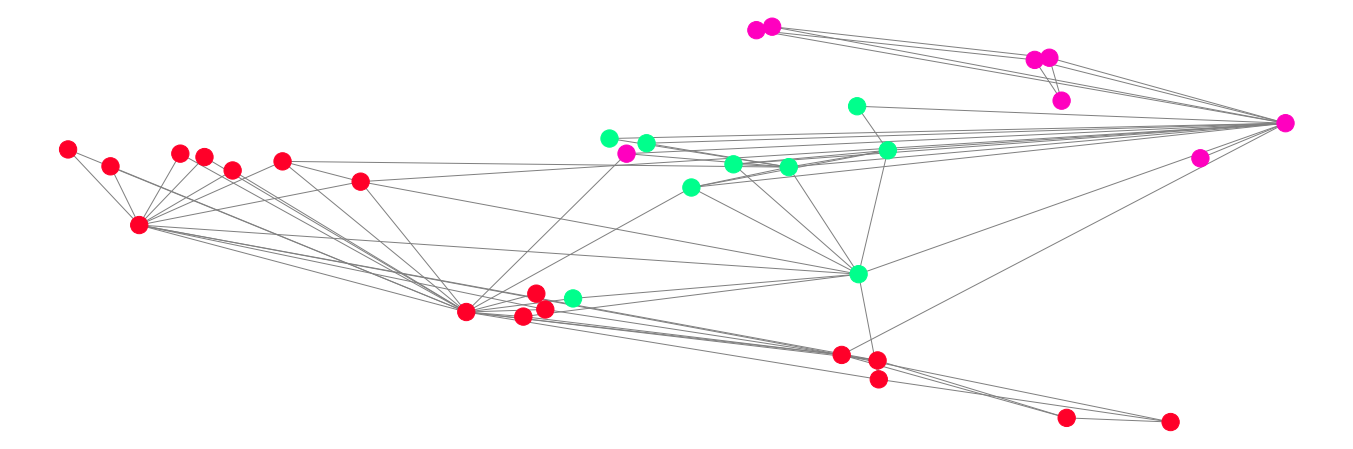

In [168]:
# Visualize Imprioving Embeddings

fig, ax = plt.subplots(figsize=(24, 8))

def graph_frame(idx):
    ax.clear()
    pos = {i: history["embeddings"][idx][i,:] for i in range(history["embeddings"][idx].shape[0])}
    nx.draw(
            graph, pos,
            node_color=colors, 
            ax=ax, 
            cmap = 'gist_rainbow',
            edge_color = 'gray')
    
anim = anm.FuncAnimation(fig, graph_frame, frames=len(history["embeddings"]), interval=30, repeat=False)

In [169]:
HTML(anim.to_html5_video())